In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import scipy.stats as stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

In [62]:
def carregar_dados(caminho_csv):
    """Carrega e prepara os dados para análise"""
    df = pd.read_csv(caminho_csv)
    
    # Separar colunas de contagem e percentual
    count_cols = [col for col in df.columns if col.startswith('count_')]
    perc_cols = [col for col in df.columns if col.startswith('perc_')]
    
    # Extrair tipos de MC³
    mc3_types = [col.replace('count_', '') for col in count_cols]
    
    print(f"Dataset carregado com {len(df)} questões")
    print(f"MC³ tipos detectados: {mc3_types}")
    print(f"Colunas disponíveis: {df.columns.tolist()}")
    
    return df, mc3_types, count_cols, perc_cols


def analise_estatistica_basica(df, mc3_types, count_cols, perc_cols):
    """Análise estatística descritiva dos dados"""
    
    print("\n=== ESTATÍSTICAS BÁSICAS ===")
    
    # Estatísticas gerais
    total_usuarios = df['usuarios_analisados'].sum()
    total_com_misconceptions = df['usuarios_com_misconceptions'].sum()
    media_misconceptions_por_questao = df['percentual_com_misconceptions'].mean()
    
    print(f"Total de usuários analisados: {total_usuarios}")
    print(f"Total com misconceptions: {total_com_misconceptions}")
    print(f"Percentual global com misconceptions: {(total_com_misconceptions/total_usuarios)*100:.2f}%")
    print(f"Média de misconceptions por questão: {media_misconceptions_por_questao:.2f}%")
    
    # Top MC³ mais frequentes
    mc3_totals = {}
    for mc3 in mc3_types:
        total_count = df[f'count_{mc3}'].sum()
        avg_perc = df[f'perc_{mc3}'].mean()
        mc3_totals[mc3] = {'total': total_count, 'avg_perc': avg_perc}
    
    # Ordenar por frequência total
    top_mc3 = sorted(mc3_totals.items(), key=lambda x: x[1]['total'], reverse=True)
    
    print(f"\n=== TOP 10 MC³ MAIS FREQUENTES ===")
    for i, (mc3, stats_dict) in enumerate(top_mc3[:10]):
        print(f"{i+1:2d}. {mc3}: {stats_dict['total']:3d} ocorrências ({stats_dict['avg_perc']:5.2f}% média)")
    
    return mc3_totals, top_mc3


In [63]:




# VISUALIZAÇÕES - ANÁLISE GERAL

def criar_graficos_gerais(df, mc3_types, top_mc3, num_mc3=10):
    """
    Cria apenas o gráfico dos MC³ mais frequentes
    
    Parameters:
    - df: DataFrame com os dados
    - mc3_types: tipos de MC³
    - top_mc3: lista dos MC³ mais frequentes
    - num_mc3: número de MC³ para mostrar (padrão: 10, use -1 para todos)
    """
    # Determinar quantos MC³ mostrar
    if num_mc3 == -1:
        mc3_para_mostrar = top_mc3
        titulo_suffix = "Todos"
    else:
        mc3_para_mostrar = top_mc3[:num_mc3]
        titulo_suffix = f"Top {num_mc3}"

    # Criar figura com fundo branco liso
    fig, ax = plt.subplots(figsize=(12, 8), facecolor='white')
    ax.set_facecolor('white')  # Fundo dos eixos

    # Dados para o gráfico
    mc3_names = [item[0] for item in mc3_para_mostrar]
    mc3_counts = [item[1]['total'] for item in mc3_para_mostrar]

    # Cores variadas
    colors = plt.cm.Set3(np.linspace(0, 1, len(mc3_para_mostrar)))

    # Criar gráfico
    bars = ax.bar(mc3_names, mc3_counts, color=colors)

    # Títulos e rótulos
    ax.set_title(f'{titulo_suffix} MC³ Mais Frequentes', fontsize=16, fontweight='bold')
    ax.set_xlabel('Tipo de MC³')
    ax.set_ylabel('Contagem Total')
    ax.set_xticks(range(len(mc3_names)))
    ax.set_xticklabels(mc3_names, rotation=45)

    # Adicionar rótulos nas barras
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + height * 0.01,
                f'{int(height)}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()



# ANÁLISE DE CORRELAÇÕES

def analise_correlacoes(df, mc3_types, incluir_zeros=False):
    """
    Análise de correlações entre MC³ (usando percentuais).

    Parâmetros:
        df (DataFrame): DataFrame contendo colunas com prefixo 'perc_' para cada MC³.
        mc3_types (list): Lista dos códigos dos MC³ (ex: ['A4', 'B8', 'C1', ...]).
        incluir_zeros (bool): Se False, remove MC³ com soma total de 0.

    Retorna:
        correlation_matrix (DataFrame): Matriz de correlação entre os MC³.
        correlations_list (list): Lista das correlações ordenadas por força (valor absoluto).
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np

    print("\n=== ANÁLISE DE CORRELAÇÕES ===")

    # Colunas de percentual dos MC³
    perc_columns = [f'perc_{mc3}' for mc3 in mc3_types]
    df_perc = df[perc_columns].copy()

    # Filtrar MC³ com soma total zero, se necessário
    if not incluir_zeros:
        non_zero_mc3 = [mc3 for mc3 in mc3_types if df[f'perc_{mc3}'].sum() > 0]
        perc_columns = [f'perc_{mc3}' for mc3 in non_zero_mc3]
        df_perc = df[perc_columns]
        mc3_types = non_zero_mc3

    # Matriz de correlação
    correlation_matrix = df_perc.corr()
    correlation_matrix.columns = mc3_types
    correlation_matrix.index = mc3_types

    # Plotar heatmap SEM máscara
    plt.figure(figsize=(16, 14))
    sns.set(style="white")  # Remove fundo listrado

    sns.heatmap(
        correlation_matrix,
        annot=True,
        fmt='.2f',
        cmap='RdBu_r',
        center=0,
        square=False,  # Para ajustar corretamente ao tamanho do eixo
        linewidths=0.5,  # Linha fina entre células
        cbar_kws={'label': 'Correlação'}
    )

    plt.title('Matriz de Correlação entre MC³ (Percentuais)', fontsize=16)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # Lista de correlações mais fortes (valor absoluto)
    correlations_list = []
    for i in range(len(mc3_types)):
        for j in range(i + 1, len(mc3_types)):
            corr_value = correlation_matrix.iloc[i, j]
            correlations_list.append((mc3_types[i], mc3_types[j], corr_value))

    correlations_list.sort(key=lambda x: abs(x[2]), reverse=True)

    # Exibir top 10 correlações mais fortes
    print("Top 10 correlações mais fortes:")
    for i, (mc3_1, mc3_2, corr) in enumerate(correlations_list[:10]):
        print(f"{i+1:2d}. {mc3_1} ↔ {mc3_2}: {corr:6.3f}")

    return correlation_matrix, correlations_list










In [64]:
# Configurações de visualização
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)


# Carregar dados
caminho_csv = "misconceptions_summary_por_questao.csv"
df, mc3_types, count_cols, perc_cols = carregar_dados(caminho_csv)

# Mostrar overview dos dados
print("\n=== OVERVIEW DOS DADOS ===")
df.describe()




Dataset carregado com 164 questões
MC³ tipos detectados: ['A4', 'A5', 'B4', 'B6', 'B8', 'B9', 'B12', 'C1', 'C2', 'C3', 'C4', 'C8', 'D4', 'E2', 'G4', 'G5', 'H1']
Colunas disponíveis: ['questao_id', 'total_usuarios_responderam', 'usuarios_analisados', 'usuarios_com_misconceptions', 'percentual_com_misconceptions', 'count_A4', 'perc_A4', 'count_A5', 'perc_A5', 'count_B4', 'perc_B4', 'count_B6', 'perc_B6', 'count_B8', 'perc_B8', 'count_B9', 'perc_B9', 'count_B12', 'perc_B12', 'count_C1', 'perc_C1', 'count_C2', 'perc_C2', 'count_C3', 'perc_C3', 'count_C4', 'perc_C4', 'count_C8', 'perc_C8', 'count_D4', 'perc_D4', 'count_E2', 'perc_E2', 'count_G4', 'perc_G4', 'count_G5', 'perc_G5', 'count_H1', 'perc_H1']

=== OVERVIEW DOS DADOS ===


,questao_id,total_usuarios_responderam,usuarios_analisados,usuarios_com_misconceptions,percentual_com_misconceptions,count_A4,perc_A4,count_A5,perc_A5,count_B4,perc_B4,count_B6,perc_B6,count_B8,perc_B8,count_B9,perc_B9,count_B12,perc_B12,count_C1,perc_C1,count_C2,perc_C2,count_C3,perc_C3,count_C4,perc_C4,count_C8,perc_C8,count_D4,perc_D4,count_E2,perc_E2,count_G4,perc_G4,count_G5,perc_G5,count_H1,perc_H1
count,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000,164.0,164.0,164.000000,164.000000,164.000000,164.000000,164.0,164.0,164.000000,164.000000,164.0,164.0,164.0,164.0,164.0,164.0,164.000000,164.000000,164.000000,164.000000,164.0,164.0,164.000000,164.000000,164.000000,164.000000,164.000000,164.000000
mean,6080.878049,20.859756,20.859756,20.835366,99.877683,2.573171,12.356402,20.695122,99.185061,13.597561,65.259207,0.0,0.0,20.609756,98.777500,14.256098,68.292622,0.0,0.0,0.932927,4.466159,0.0,0.0,0.0,0.0,0.0,0.0,1.871951,8.973720,2.926829,14.015549,0.0,0.0,20.835366,99.877683,3.243902,15.524634,0.920732,4.432195
std,1150.081799,4.275608,4.275608,4.280470,0.787085,1.452989,6.690195,4.302058,2.195588,3.353818,10.144487,0.0,0.0,4.285104,2.684203,3.486384,9.347899,0.0,0.0,0.985360,4.848885,0.0,0.0,0.0,0.0,0.0,0.0,1.282996,6.070345,1.607349,7.460018,0.0,0.0,4.280470,0.787085,1.539349,6.935655,0.857910,4.245246
min,1642.000000,16.000000,16.000000,15.000000,93.750000,0.000000,0.000000,14.000000,87.500000,7.000000,31.820000,0.0,0.0,14.000000,87.500000,8.000000,44.440000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,15.000000,93.750000,0.000000,0.000000,0.000000,0.000000
25%,6008.750000,18.000000,18.000000,18.000000,100.000000,1.000000,6.250000,17.000000,100.000000,11.000000,57.840000,0.0,0.0,17.000000,100.000000,11.000000,62.500000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,5.000000,2.000000,8.525000,0.0,0.0,18.000000,100.000000,2.000000,11.110000,0.000000,0.000000
50%,6366.500000,20.000000,20.000000,20.000000,100.000000,3.000000,11.760000,20.000000,100.000000,13.000000,64.710000,0.0,0.0,20.000000,100.000000,14.000000,68.420000,0.0,0.0,1.000000,4.170000,0.0,0.0,0.0,0.0,0.0,0.0,2.000000,8.515000,3.000000,14.810000,0.0,0.0,20.000000,100.000000,3.000000,15.000000,1.000000,4.550000
75%,6751.250000,24.000000,24.000000,24.000000,100.000000,3.000000,17.455000,23.000000,100.000000,16.000000,72.730000,0.0,0.0,23.000000,100.000000,17.000000,75.000000,0.0,0.0,1.000000,6.250000,0.0,0.0,0.0,0.0,0.0,0.0,3.000000,12.500000,4.000000,18.750000,0.0,0.0,24.000000,100.000000,4.000000,20.000000,1.000000,6.250000
max,7050.000000,41.000000,41.000000,41.000000,100.000000,7.000000,33.330000,41.000000,100.000000,27.000000,90.000000,0.0,0.0,40.000000,100.000000,26.000000,88.890000,0.0,0.0,4.000000,23.530000,0.0,0.0,0.0,0.0,0.0,0.0,7.000000,33.330000,8.000000,31.820000,0.0,0.0,41.000000,100.000000,8.000000,37.500000,3.000000,17.650000


In [65]:

mc3_totals, top_mc3 = analise_estatistica_basica(df, mc3_types, count_cols, perc_cols)




=== ESTATÍSTICAS BÁSICAS ===
Total de usuários analisados: 3421
Total com misconceptions: 3417
Percentual global com misconceptions: 99.88%
Média de misconceptions por questão: 99.88%

=== TOP 10 MC³ MAIS FREQUENTES ===
 1. G4: 3417 ocorrências (99.88% média)
 2. A5: 3394 ocorrências (99.19% média)
 3. B8: 3380 ocorrências (98.78% média)
 4. B9: 2338 ocorrências (68.29% média)
 5. B4: 2230 ocorrências (65.26% média)
 6. G5: 532 ocorrências (15.52% média)
 7. D4: 480 ocorrências (14.02% média)
 8. A4: 422 ocorrências (12.36% média)
 9. C8: 307 ocorrências ( 8.97% média)
10. C1: 153 ocorrências ( 4.47% média)


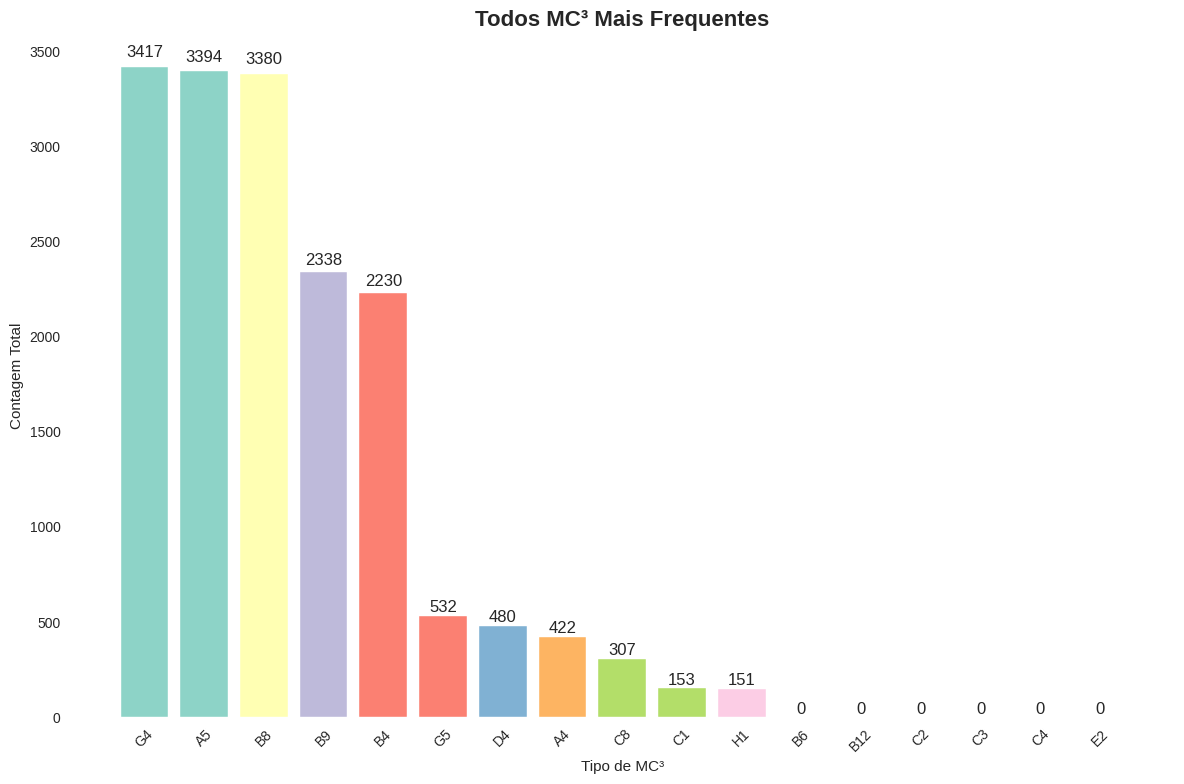

In [66]:
criar_graficos_gerais(df, mc3_types, top_mc3,-1)





=== ANÁLISE DE CORRELAÇÕES ===


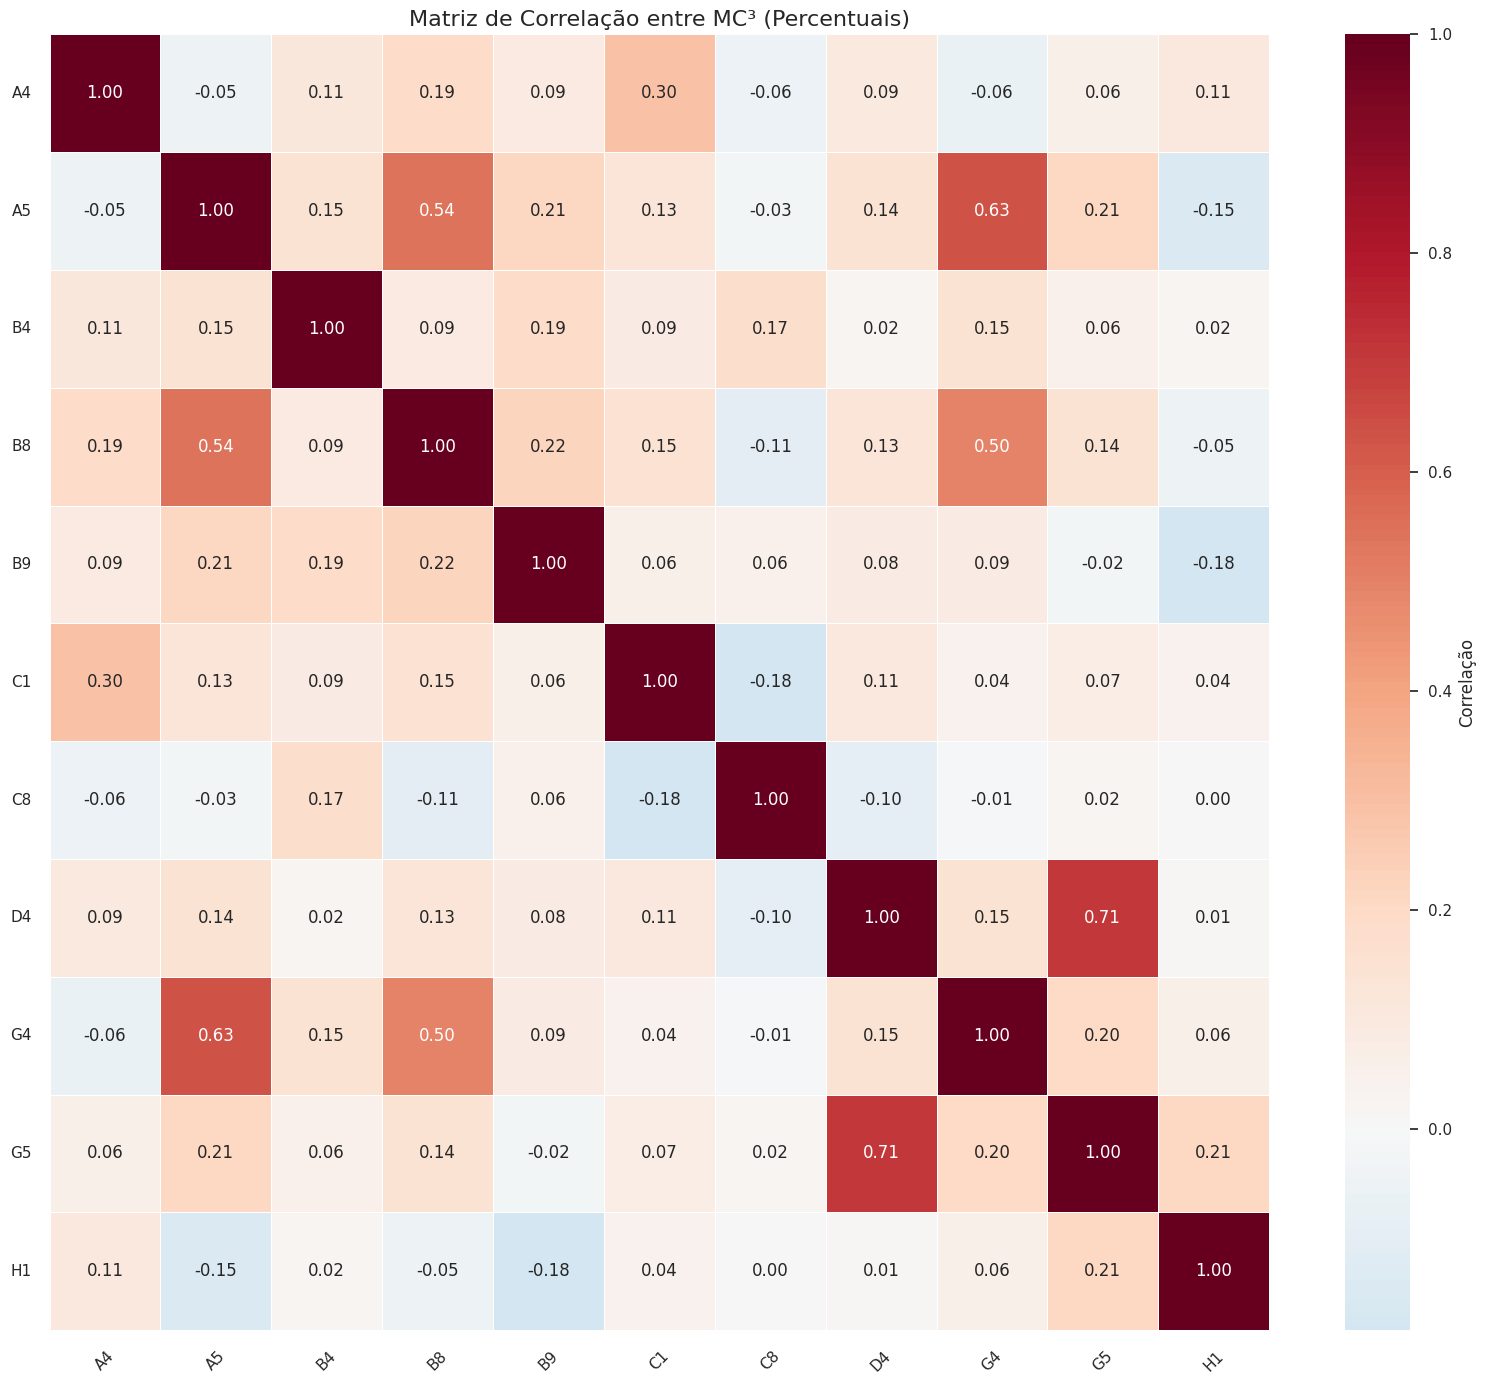

Top 10 correlações mais fortes:
 1. D4 ↔ G5:  0.705
 2. A5 ↔ G4:  0.635
 3. A5 ↔ B8:  0.540
 4. B8 ↔ G4:  0.495
 5. A4 ↔ C1:  0.296
 6. B8 ↔ B9:  0.224
 7. A5 ↔ B9:  0.212
 8. A5 ↔ G5:  0.208
 9. G5 ↔ H1:  0.206
10. G4 ↔ G5:  0.198


In [67]:
correlation_matrix, correlations_list = analise_correlacoes(df, mc3_types)

